# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />

In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal

import json
import matplotlib.pyplot as plt

## Probabilistic Principal Components Analysis (PPCA)

In [30]:
class ProbabilisticPCA:
  #
  def __init__(self, L, epochs=50, seed=42):
    self.L = L
    self.epochs = epochs
    self.seed = seed
    
    self.mu = None
    self.W = None
    self.sigma2 = None
    self.likelihoods = None
   
  # 
  def fit(self, X, verbose=False):
    np.random.seed(self.seed)
    
    #
    N, D = X.shape
    L = min(max(1, self.L), D) # Safety
    
    # Step 1.1
    mu = np.mean(X, axis=0)
    W = np.random.normal(0, 0.1, size=(D, L))
    sigma2 = np.var(X, axis=0).mean() # Variância média
    
    #
    likelihoods = np.zeros(self.epochs)
    
    # Epochs
    for e in range(self.epochs):
      # "Progress bar"
      if verbose:
        print(f'[ {"#" * (e + 1)}{"-" * (self.epochs - e - 1)} ]: {e + 1}/{self.epochs}', end="\r")
        
      # Step E / Step 2.1
      Minv = np.linalg.inv(W.T @ W + sigma2 * np.eye(L))
      MinvWT = Minv @ W.T

      Ez = np.zeros((N, L))
      EzzT = np.zeros((N, L, L))

      for i in range(N):
          diff = X[i] - mu
          Ez[i] = MinvWT @ diff
          EzzT[i] = sigma2 * Minv + np.outer(Ez[i], Ez[i])
 
      # Step M / Step 2.2
      W = np.zeros((D, L))
      for i in range(N):
          diff = X[i] - mu
          W += np.outer(diff, Ez[i])

      W = W @ np.linalg.inv(np.sum(EzzT, axis=0))
      
      #
      sigma2_ = 0
      for i in range(N):
          diff = X[i] - mu
          sigma2_ += np.linalg.norm(diff)**2 - 2 * np.dot(Ez[i], W.T @ diff) + np.trace(EzzT[i] @ W.T @ W)

      sigma2 = (1 / (N * D)) * sigma2_
      
      # Likelihood      
      try:
          Sigma = W @ W.T + sigma2 * np.eye(D)
          SigmaInv = np.linalg.inv(Sigma)
          
          chocho = np.linalg.cholesky(Sigma)
          logdet = 2 * np.sum(np.log(np.diag(chocho)))
          last = np.sum(np.einsum('ni,ij,nj->n', X - mu, SigmaInv, X - mu))
          
          likelihoods[e] = (-0.5 * N * D * np.log(2 * np.pi) - 0.5 * N * logdet - 0.5 * last)
      except np.linalg.LinAlgError:
          likelihoods[e] = -np.inf
          break # Deu ruim: Sigma não determinado

    # Safety
    if verbose:
      print('Fim', end='\r')
        
    self.mu = mu
    self.W = W
    self.sigma2 = sigma2
    self.likelihoods = likelihoods

  #
  def save(self, filename):
    data = {
      'L': self.L,
      'epochs': self.epochs,
      'seed': self.seed,
      
      'mu': self.mu.tolist() if self.mu is not None else None,
      'W': self.W.tolist() if self.W is not None else None,
      'likelihoods': self.likelihoods.tolist() if self.likelihoods is not None else None,
      'sigma2': self.sigma2,
    }
    
    with open(filename, 'w') as file:
      json.dump(data, file, indent=2)
     
  # 
  @classmethod
  def load(cls, filename):
    with open(filename, 'r') as file:
      data = json.load(file)
      
      instance = cls(L=data['L'], epochs=data['epochs'], seed=data['seed'])
      instance.mu = np.array(data['mu']) if data['mu'] is not None else None
      instance.W = np.array(data['W']) if data['W'] is not None else None
      instance.likelihoods = np.array(data['likelihoods']) if data['likelihoods'] is not None else None
      instance.sigma2 = np.array(data['sigma2'])
      
      return instance
    
  #
  def __str__(self):
      return f"ProbabilisticPCA: (L → {self.L})(Epochs → {self.epochs})"

#### Carregamento dos dados

In [8]:
# Data
X = np.genfromtxt('./files/mnist_5.csv', delimiter=',')
X.shape

(6313, 784)

#### Training

In [19]:
def run(X, Ls, epochs=50, seed=42, verbose=False, path=None):
  models = []
  
  for L in Ls:
    ppca = ProbabilisticPCA(L=L, seed=seed, epochs=epochs)
    
    if verbose:
      print(ppca)
      
    ppca.fit(X, verbose=verbose)
    models.append(ppca)
    
    if path:
      filename = f'{path}L{ppca.L}E{ppca.epochs}S{ppca.seed}.json'
      ppca.save(filename)
      
      if verbose:
        print("Saved: ", filename)
    
  return models

ProbabilisticPCA: (L → 2)(Epochs → 4)
Saved:  ./files/saves/L2-E4-S42.json
ProbabilisticPCA: (L → 3)(Epochs → 4)
Saved:  ./files/saves/L3-E4-S42.json
CPU times: user 1min 27s, sys: 546 ms, total: 1min 27s
Wall time: 1min 28s


In [ ]:
# Just in case
if 'models' not in globals():
  path = './files/saves/'
  models = [ProbabilisticPCA.load(f'{path}L{L}E4S42.json') for L in [2, 3]]
  
  print('Loaded')

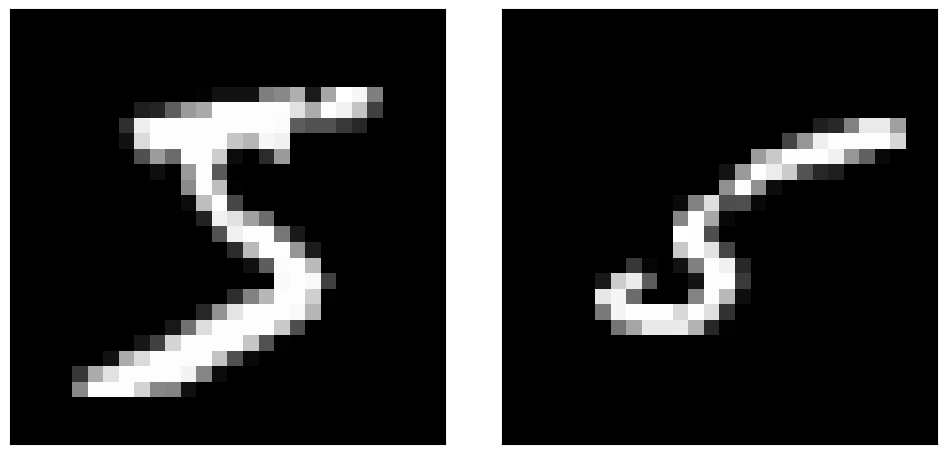

In [44]:
def sidebyside(left, right):
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  fig.tight_layout()

  axs[0].imshow(left.reshape(28, 28),  cmap='gray'), axs[0].set_xticks([]), axs[0].set_yticks([])
  axs[1].imshow(right.reshape(28, 28), cmap='gray'), axs[1].set_xticks([]), axs[1].set_yticks([])

sidebyside(X[0], X[1])

In [275]:
# Likelihood
# epsilon = 1e-6
L = 2
M = W.T @ W + sigma2 * np.eye(L)

Sigma = W @ W.T + sigma2 * np.eye(D)
# SigmaInv = 0.5 * sigma2 * np.eye(D) -0.5 * sigma2 * (W @ np.linalg.inv(M) @ W.T) # Usando identidade de Woodbury
# logdet = 2 * np.sum(np.log(np.diag(np.linalg.cholesky(Sigma)))) # Usando Cholesky
 
# part = 0

# for i in range(N):
#   diff = X[i] - mu
#   part += diff @ SigmaInv @ diff
  
# likelihood.append((-0.5 * (N * D) * np.log(2 * np.pi)) - (0.5 * N * logdet) - (0.5 * part))
# likelihood[-1]

np.float64(-2.6637497359477565e+23)